In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import clear_output
from time import sleep
import os

In [2]:
Train_Dir = 'input/training/training.csv'
Test_Dir = 'input/test/test.csv'
lookid_dir = 'input/IdLookupTable.csv'

train_data = pd.read_csv(Train_Dir)  
test_data = pd.read_csv(Test_Dir)
lookid_data = pd.read_csv(lookid_dir)
os.listdir('input')

['training', 'test', 'IdLookupTable.csv', 'SampleSubmission.csv']

In [3]:
train_data.head().T

,0,1,2,3,4
left_eye_center_x,66.033564,64.332936,65.057053,65.225739,66.725301
left_eye_center_y,39.002274,34.970077,34.909642,37.261774,39.621261
right_eye_center_x,30.227008,29.949277,30.903789,32.023096,32.24481
right_eye_center_y,36.421678,33.448715,34.909642,37.261774,38.042032
left_eye_inner_corner_x,59.582075,58.85617,59.412,60.003339,58.56589
left_eye_inner_corner_y,39.647423,35.274349,36.320968,39.127179,39.621261
left_eye_outer_corner_x,73.130346,70.722723,70.984421,72.314713,72.515926
left_eye_outer_corner_y,39.969997,36.187166,36.320968,38.380967,39.884466
right_eye_inner_corner_x,36.356571,36.034723,37.678105,37.618643,36.98238
right_eye_inner_corner_y,37.389402,34.361532,36.320968,38.754115,39.094852


In [4]:
# 含有缺失列的数量
train_data.isnull().any().value_counts()

True     28
False     3
Name: count, dtype: int64

In [5]:
train_data.fillna(method = 'ffill',inplace = True)
# 缺失值均值填充
# train_data.fillna(train_data.mean(),inplace = True)

/tmp/ipykernel_2156143/2758346389.py:1: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  train_data.fillna(method = 'ffill',inplace = True)


In [6]:
train_data.isnull().any().value_counts()

False    31
Name: count, dtype: int64

In [9]:
images = []
for i in range(len(train_data)):
    img = train_data['Image'][i].split(' ')
    img = ['0' if x == '' else x for x in img]
    images.append(img)

In [10]:
image_list = np.array(images,dtype = 'float')
X_train = image_list.reshape(-1,96,96,1)

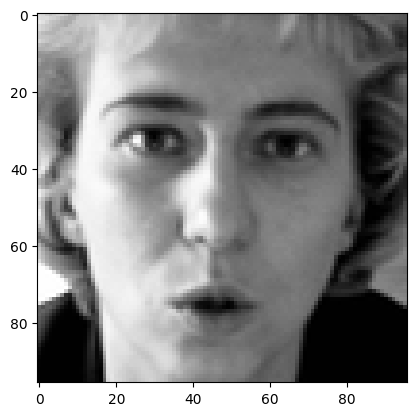

In [15]:
plt.imshow(X_train[1].reshape(96,96),cmap='gray')
plt.show()

In [16]:
training = train_data.drop('Image',axis = 1)

y_train = []
for i in range(len(training)):
    y = training.iloc[i,:]

    y_train.append(y)
y_train = np.array(y_train,dtype = 'float')

In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F
from sklearn.model_selection import train_test_split

class KeypointModel(nn.Module):
    def __init__(self):
        super(KeypointModel, self).__init__()
        
        # 定义卷积层、批归一化层和激活函数
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1, bias=False),
            nn.LeakyReLU(negative_slope=0.1),
            nn.BatchNorm2d(32),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1, bias=False),
            nn.LeakyReLU(negative_slope=0.1),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1, bias=False),
            nn.LeakyReLU(negative_slope=0.1),
            nn.BatchNorm2d(64),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1, bias=False),
            nn.LeakyReLU(negative_slope=0.1),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=96, kernel_size=3, padding=1, bias=False),
            nn.LeakyReLU(negative_slope=0.1),
            nn.BatchNorm2d(96),
            nn.Conv2d(in_channels=96, out_channels=96, kernel_size=3, padding=1, bias=False),
            nn.LeakyReLU(negative_slope=0.1),
            nn.BatchNorm2d(96),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=96, out_channels=128, kernel_size=3, padding=1, bias=False),
            nn.LeakyReLU(negative_slope=0.1),
            nn.BatchNorm2d(128),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1, bias=False),
            nn.LeakyReLU(negative_slope=0.1),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.conv5 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1, bias=False),
            nn.LeakyReLU(negative_slope=0.1),
            nn.BatchNorm2d(256),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1, bias=False),
            nn.LeakyReLU(negative_slope=0.1),
            nn.BatchNorm2d(256),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.conv6 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1, bias=False),
            nn.LeakyReLU(negative_slope=0.1),
            nn.BatchNorm2d(512),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1, bias=False),
            nn.LeakyReLU(negative_slope=0.1),
            nn.BatchNorm2d(512)
        )
        
        # 定义全连接层
        # 经过5次池化，96x96 -> 48x48 -> 24x24 -> 12x12 -> 6x6 -> 3x3
        # 展平后的维度为 512 * 3 * 3 = 4608
        self.fc = nn.Sequential(
            nn.Linear(512 * 3 * 3, 512),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(512, 30)
        )

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = self.conv6(x)
        
        # 展平操作
        x = x.view(x.size(0), -1)
        
        x = self.fc(x)
        return x

In [18]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
model = KeypointModel().to(device)
# print(model)

Using device: cpu


/home/tianhaojiang/.conda/envs/fkd_env/lib/python3.9/site-packages/torch/cuda/__init__.py:82: UserWarning: CUDA initialization: Unexpected error from cudaGetDeviceCount(). Did you run some cuda functions before calling NumCudaDevices() that might have already set an error? Error 804: forward compatibility was attempted on non supported HW (Triggered internally at  ../c10/cuda/CUDAFunctions.cpp:112.)
  return torch._C._cuda_getDeviceCount() > 0


In [19]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters())

In [20]:
X_train_tensor = torch.from_numpy(X_train).permute(0, 3, 1, 2).float()
y_train_tensor = torch.from_numpy(y_train).float()

X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
    X_train_tensor, y_train_tensor, test_size=0.2, random_state=42
)

# 创建 DataLoader
train_dataset = TensorDataset(X_train_split, y_train_split)
val_dataset = TensorDataset(X_val_split, y_val_split)

train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=256, shuffle=False)

In [21]:
epochs = 50
best_val_loss = float('inf')
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    running_mae = 0.0
    for i, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        # 计算 MAE
        running_mae += F.l1_loss(outputs, labels).item()

    # 验证
    model.eval()
    val_loss = 0.0
    val_mae = 0.0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            val_mae += F.l1_loss(outputs, labels).item()
    
    print(f"Epoch {epoch+1}/{epochs}, "
          f"Loss: {running_loss/len(train_loader):.4f}, "
          f"MAE: {running_mae/len(train_loader):.4f}, "
          f"Val Loss: {val_loss/len(val_loader):.4f}, "
          f"Val MAE: {val_mae/len(val_loader):.4f}")
    
    current_val_loss = val_loss/len(val_loader)
    if current_val_loss < best_val_loss:
        best_val_loss = current_val_loss
        torch.save(model.state_dict(), 'best_model.pth')
        print(f"Model saved at epoch {epoch+1} with Val Loss: {best_val_loss:.4f}")

print('Finished Training')

Epoch 1/50, Loss: 541.3189, MAE: 15.6538, Val Loss: 99.9207, Val MAE: 8.7086
Model saved at epoch 1 with Val Loss: 99.9207
Epoch 2/50, Loss: 21.4330, MAE: 3.5222, Val Loss: 12.5417, Val MAE: 2.3767
Model saved at epoch 2 with Val Loss: 12.5417
Epoch 3/50, Loss: 15.2827, MAE: 2.8878, Val Loss: 9.0786, Val MAE: 1.9490
Model saved at epoch 3 with Val Loss: 9.0786
Epoch 4/50, Loss: 14.4987, MAE: 2.8071, Val Loss: 9.1967, Val MAE: 1.9381
Epoch 5/50, Loss: 14.3409, MAE: 2.7807, Val Loss: 11.9497, Val MAE: 2.5149
Epoch 6/50, Loss: 14.4435, MAE: 2.7824, Val Loss: 8.5119, Val MAE: 1.8787
Model saved at epoch 6 with Val Loss: 8.5119
Epoch 7/50, Loss: 13.0659, MAE: 2.6466, Val Loss: 8.1493, Val MAE: 1.7854
Model saved at epoch 7 with Val Loss: 8.1493
Epoch 8/50, Loss: 14.3234, MAE: 2.6288, Val Loss: 10.8630, Val MAE: 2.3009
Epoch 9/50, Loss: 13.9613, MAE: 2.7433, Val Loss: 8.1009, Val MAE: 1.8551
Model saved at epoch 9 with Val Loss: 8.1009
Epoch 10/50, Loss: 11.7706, MAE: 2.5064, Val Loss: 10.26

In [22]:
test_images = []
for i in range(len(test_data)):
    test_img = test_data['Image'][i].split(' ')
    test_img = ['0' if x == '' else x for x in test_img]

    test_images.append(test_img)

In [23]:
test_images_list = np.array(test_images,dtype = 'float')
X_test = test_images_list.reshape(-1,96,96,1)

In [24]:
model_best = KeypointModel().to(device)
model_best.load_state_dict(torch.load('best_model.pth'))

model_best.eval()

X_test_tensor = torch.from_numpy(X_test).permute(0, 3, 1, 2).float().to(device)

with torch.no_grad():
    pred_tensor = model_best(X_test_tensor)

pred = pred_tensor.cpu().numpy()

In [25]:
lookid_list = list(lookid_data['FeatureName'])
imageID = list(lookid_data['ImageId'])
pred_dict = list(pred)
rowID = lookid_data['RowId']
rowID = list(rowID)

In [27]:
feature_names = list(training.columns)

feature_to_idx = {name: i for i, name in enumerate(feature_names)}

image_ids_to_lookup = lookid_data['ImageId']
features_to_lookup = lookid_data['FeatureName']

locations = [pred[image_id - 1][feature_to_idx[feature_name]] 
             for image_id, feature_name in zip(image_ids_to_lookup, features_to_lookup)]

In [28]:
submission = pd.DataFrame({
    "RowId": lookid_data['RowId'],
    "Location": locations
})
submission.to_csv('face_key_detection_submission.csv', index=False)
submission.head()

,RowId,Location
0,1,68.177933
1,2,36.078697
2,3,29.323975
3,4,35.695274
4,5,60.981773
